In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
from bisect import bisect
torch.cuda.is_available()

True

In [2]:
import pandas as pd
import pyarrow.parquet as pq

# def read_parquet_in_chunks(file_path, chunk_size=100):
#     dfs = []
#     pf = pq.ParquetFile(file_path)
#     for i in range(0, pf.num_row_groups, chunk_size):
#         chunk = pf.read_row_group(i).to_pandas()
#         dfs.append(chunk)
#     return pd.concat(dfs, ignore_index=True)

file1 = 'QCDToGGQQ_IMGjet_RH1all_jet0_run0_n36272.test.snappy.parquet'
file2 = 'QCDToGGQQ_IMGjet_RH1all_jet0_run1_n47540.test.snappy.parquet'
file3 = 'QCDToGGQQ_IMGjet_RH1all_jet0_run2_n55494.test.snappy.parquet'

# df1 = read_parquet_in_chunks(file1)
# df2 = read_parquet_in_chunks(file2)
# df3 = read_parquet_in_chunks(file3)

# # Combine the DataFrames
# df = pd.concat([df1, df2, df3], ignore_index=True)




In [3]:
class ParquetDataset(Dataset):
    def __init__(self, file_path):
        self.file_path = file_path
        self.parquet_file = pq.ParquetFile(file_path)
        self.num_row_groups = self.parquet_file.num_row_groups

    def __len__(self):
        return self.num_row_groups

    def __getitem__(self, idx):
        row_group = self.parquet_file.read_row_group(idx).to_pandas()
        image_data = row_group['X_jets'].iloc[0]
        label = row_group['y'].iloc[0]

        # Stack the image data
        image_data = np.stack([np.stack(channel) for channel in image_data], axis=0).astype('float32')
        image_data = torch.tensor(image_data, dtype=torch.float)

        # Explicitly cast label to an integer
        label = int(label)
        label = torch.tensor(label, dtype=torch.long)

        return image_data, label

In [4]:
from torch.utils.data import ConcatDataset

dataset1 = ParquetDataset(file1)
dataset2 = ParquetDataset(file2)
dataset3 = ParquetDataset(file3)


dataset = ConcatDataset([dataset1, dataset2, dataset3])


In [5]:
from torch.utils.data import random_split

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [6]:
# Load the VGG16 model
from torchvision import models
vgg16 = models.vgg16(pretrained=True)

# Modify the last layer to be a binary classifier
num_features = vgg16.classifier[6].in_features
num_classes = 2
vgg16.classifier[6] = nn.Linear(num_features, num_classes)

# Set the device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg16 = vgg16.to(device)



C:\Users\roder\anaconda3\envs\pt2.0\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\roder\anaconda3\envs\pt2.0\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
# Set the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16.parameters(), lr=1e-4)

# Train the model
num_epochs = 10
reg_factor = 0.01
for epoch in range(num_epochs):
    vgg16.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = vgg16(images)
        loss = criterion(outputs, labels)
        loss += l2_regularization(vgg16, reg_factor)
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")

Epoch 1/10, Loss: 0.5757388874798577
Epoch 2/10, Loss: 0.5574199608215613
Epoch 3/10, Loss: 0.5483359148832289
Epoch 4/10, Loss: 0.540307342099144
Epoch 5/10, Loss: 0.5292726373436326
Epoch 6/10, Loss: 0.5146590056105862
Epoch 7/10, Loss: 0.4883524956817501
Epoch 8/10, Loss: 0.4442600371541218
Epoch 9/10, Loss: 0.3740460388415886
Epoch 10/10, Loss: 0.2863731180247376


In [8]:
# Set the model to evaluation mode
vgg16.eval()

# Initialize variables for accuracy calculation
correct = 0
total = 0
# Disable gradient computation to save memory and speed up the evaluation
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Make predictions
        outputs = vgg16(images)
        
        # Get the predicted class (highest value)
        _, predicted = torch.max(outputs.data, 1)
        
        # Update the total number of samples and the number of correct predictions
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate the accuracy
accuracy = correct / total
print(f'Accuracy of the model on the test dataset: {accuracy * 100:.2f}%')


Accuracy of the model on the test dataset: 69.49%


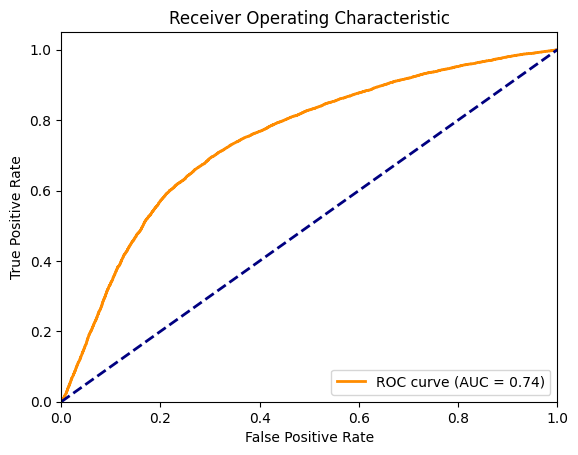

In [10]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
# Set the model to evaluation mode
vgg16.eval()

# Initialize lists to store true labels and predicted probabilities
y_true = []
y_probs = []

# Disable gradient computation to save memory and speed up the evaluation
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Make predictions
        outputs = vgg16(images)
        
        # Get the probability of the positive class (class 1)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        probs = probs[:, 1].cpu().numpy()
        
        y_probs.extend(probs)
        y_true.extend(labels.cpu().numpy())

# Compute ROC curve and AUC score
fpr, tpr, _ = roc_curve(y_true, y_probs)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [11]:
torch.save(vgg16.state_dict(), 'task2.pt')